In this example the goal is to estimate hidden states of a Dynamical process where all hidden states are Gaussians. Our process can be described with the following two sets of equations:

$$
\begin{align*}
 & p(z_i|z_{i - 1}) = \mathcal{N}(z_{i-1},~\mathcal{I}_{2}),\\
 & p(y_i|z_i)  = \mathcal{N} \left (y_i \left \vert \begin{bmatrix} \| z_{i} - s_{1}\| \\ \|z_{i} - s_{2}\| \\ \|z_{i} - s_{3}\|\end{bmatrix}\!,~\mathcal{I}_{3}\! \right . \right)\!,
\end{align*}
$$

$$
\begin{align*}
 & p(\text{W}) = \text{Wishart}_{2} \\
 & p(\text{R}) = \text{Wishart}_{3} \\
 & p(z_i|z_{i - 1}) = \mathcal{N}(z_{i-1},~W),\\
 & p(y_i|z_i)  = \mathcal{N} \left (y_i \left \vert \begin{bmatrix} \| z_{i} - s_{1}\| \\ \|z_{i} - s_{2}\| \\ \|z_{i} - s_{3}\|\end{bmatrix}\!,~R\! \right . \right)\!,
\end{align*}
$$

where $z_i$ are hidden states, $y_i$ are noisy nonlinear observations. In the second set of the equations, W and R are covariance matrix parameters for z, and y, respectively.

To model this process in `ReactiveMP`, first, we start with importing all needed packages:

In [146]:
using ReactiveMP, Rocket, GraphPPL
using Random, LinearAlgebra, Distributions, Plots, Flux, DataFrames, DelimitedFiles

Next step, is to load our data:

In [147]:
sensors = readdlm("data/sensor_fusion/sensors.txt")
sensor1, sensor2, sensor3 = sensors[1,:], sensors[2,:], sensors[3,:]
observation = readdlm("data/sensor_fusion/observation.txt")
position = readdlm("data/sensor_fusion/position.txt")
T = 15
observation_list = [observation[t,:] for t=1:T];

To create a model we use `GraphPPL` package and `@model` macro:

In [151]:
A = [1.0 0.0; 0.0 1.0]
# Nonlinear function that maps states to observations
function f(z)       
    pos = z
    o1 = sqrt(sum((pos-sensor1).^2))
    o2 = sqrt(sum((pos-sensor2).^2))
    o3 = sqrt(sum((pos-sensor3).^2))
    o = [o1,o2,o3]
end

@model function sensor_fusion(T)
    W = diagm(0=>ones(2))
    R = diagm(0=>ones(3))

    z = randomvar(T)
    x = randomvar(T)
    y = datavar(Vector{Float64}, T)

    z[1] ~ MvNormalMeanCovariance(zeros(2), diagm(0 => ones(2)))
    x[1] ~ f(z[1]) where {meta = CVIApproximation(2000, 100, Descent(0.1))}
    y[1] ~ MvNormalMeanCovariance(x[1], diagm(0 => ones(3)))

    for t in 2:T
        z[t] ~ MvNormalMeanPrecision(A * z[t-1], W)
        x[t] ~ f(z[t]) where {meta = CVIApproximation(2000, 100, Descent(0.1))}
        y[t] ~ MvNormalMeanPrecision(x[t], R)
    end

    return z, x, y
end

constraints = @constraints begin
    q(z, x) = q(z)q(x)
end;

To run inference we will use `inference` function from `ReactiveMP`.
Note, that for running inference for this model we need to init marginals for z messages.

In [152]:
res = inference(
    model = Model(sensor_fusion, T),
    data = (y = observation_list,),
    iterations = 10,
    free_energy = false,
    returnvars = (z = KeepLast(),),
    constraints = constraints,
    initmessages = (z = MvNormalMeanPrecision(zeros(2), 0.01*diagm(0=>ones(2))),),
);

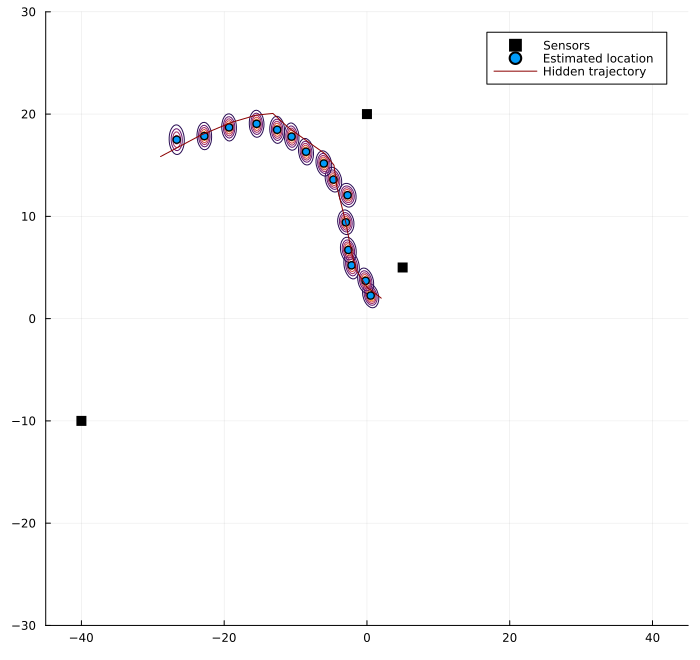

In [153]:
points = map(z -> mean(z)[1:2], res.posteriors[:z]);
x = map(z -> z[1], points);
y = map(z -> z[2], points);

L = 30
p = plot(xlim = (-1.5L, 1.5L), ylim = (-L, L))
gaussians = map(z -> MvNormal(mean(z)[1:2], cov(z)[1:2, 1:2]), res.posteriors[:z])
for (index, gaussian) in enumerate(gaussians)
    p = contour!(p, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), levels = 6, colorbar = false)
end
p = plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],
    seriestype = :scatter, color=:black, markersize=5, markershape=:square, label = "Sensors", size = [700, 660])
p = plot!(x, y, seriestype = :scatter, label = "Estimated location")
p = plot!(position'[1:15, 1], position'[1:15, 2], color=:redsblues, label = "Hidden trajectory")
p = plot!(legend=:topright)

In the following model, please note that covarience are distributions.

In [156]:
@model function sensor_fusion_unfixed_W_R(T, optimizer)
    W ~ Wishart(2, diagm(0=>ones(2)))
    R ~ Wishart(3, diagm(0=>ones(3)))

    z = randomvar(T)
    x = randomvar(T)
    y = datavar(Vector{Float64}, T)

    z[1] ~ MvNormalMeanPrecision(zeros(2), W)
    x[1] ~ f(z[1]) where {meta = CVIApproximation(2000, 100, optimizer)}
    y[1] ~ MvNormalMeanPrecision(x[1], R)

    for t in 2:T
        z[t] ~ MvNormalMeanPrecision(A * z[t-1], W)
        x[t] ~ f(z[t]) where {meta = CVIApproximation(2000, 100, optimizer)}
        y[t] ~ MvNormalMeanPrecision(x[t], R)
    end

    return z, x, y
end

constraints = @constraints begin
    q(z, x, W, R) = q(z)q(W)q(x)q(R)
end;

In [168]:
res = inference(
    model = Model(sensor_fusion_unfixed_W_R, T, Descent(0.01)),
    data = (y = observation_list,),
    iterations = 200,
    free_energy = false,
    returnvars = (z = KeepLast(),),
    constraints = constraints,
    initmessages = (z = MvNormalMeanPrecision(zeros(2), 0.01*diagm(0=>ones(2))),),
    initmarginals = (R = Wishart(3, diagm(0=>ones(3))), W = Wishart(2, diagm(0=>ones(2))))
);

Looking at the following plot, one can notice that adding additional flexibility gives a better parameter estimation: the founded states fit into the hidden trajectory better.

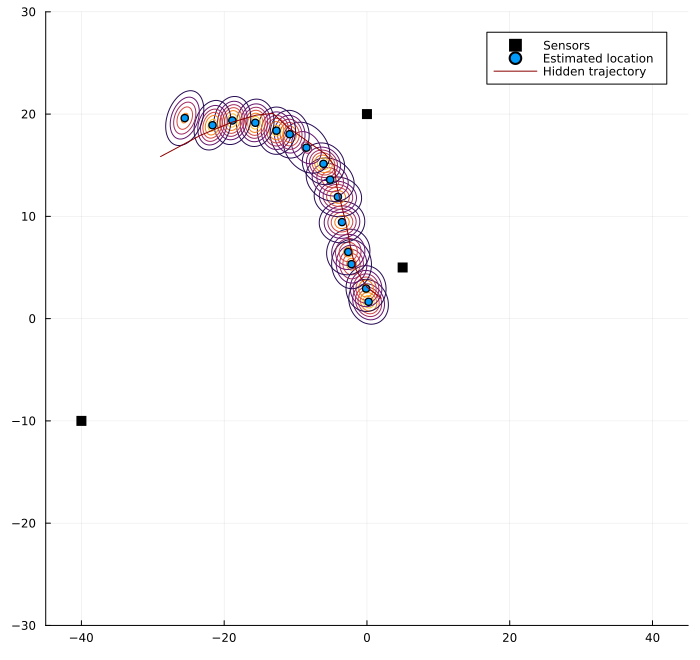

In [169]:
points = map(z -> mean(z)[1:2], res.posteriors[:z]);
x = map(z -> z[1], points);
y = map(z -> z[2], points);

L = 30
p = plot(xlim = (-1.5L, 1.5L), ylim = (-L, L))
gaussians = map(z -> MvNormal(mean(z)[1:2], cov(z)[1:2, 1:2]), res.posteriors[:z])
for (index, gaussian) in enumerate(gaussians)
    p = contour!(p, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), levels = 6, colorbar = false)
end
p = plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],
    seriestype = :scatter, color=:black, markersize=5, markershape=:square, label = "Sensors", size = [700, 660])
p = plot!(x, y, seriestype = :scatter, label = "Estimated location")
p = plot!(position'[1:15, 1], position'[1:15, 2], color=:redsblues, label = "Hidden trajectory")
p = plot!(legend=:topright)